In [48]:
import argparse
import h5py
import numpy as np
import os
import pickle
import shutil
import yaml
import json
import click
from IPython.display import Image, display
from pprint import pprint
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import vqa.lib.engine as engine
import vqa.lib.utils as utils
import vqa.lib.logger as logger
import vqa.lib.criterions as criterions
import vqa.datasets as datasets
import vqa.models as models

In [2]:
with open('options/vqa2/mutan_att_trainval.yaml', 'r') as handle:
    options = yaml.load(handle)
options['vgenome'] = None

In [3]:
options

{'coco': {'arch': 'fbresnet152',
  'dir': 'data/coco',
  'mode': 'att',
  'size': 448},
 'logs': {'dir_logs': 'logs/vqa2/mutan_att_trainval'},
 'model': {'arch': 'MutanAtt',
  'attention': {'R': 5,
   'activation_q': 'tanh',
   'activation_v': 'tanh',
   'dim_hq': 310,
   'dim_hv': 310,
   'dim_mm': 510,
   'dropout_hq': 0,
   'dropout_hv': 0,
   'dropout_mm': 0.5,
   'dropout_q': 0.5,
   'dropout_v': 0.5,
   'nb_glimpses': 2},
  'classif': {'dropout': 0.5},
  'dim_q': 2400,
  'dim_v': 2048,
  'fusion': {'R': 5,
   'activation_q': 'tanh',
   'activation_v': 'tanh',
   'dim_hq': 310,
   'dim_hv': 620,
   'dim_mm': 510,
   'dropout_hq': 0,
   'dropout_hv': 0,
   'dropout_q': 0.5,
   'dropout_v': 0.5},
  'seq2vec': {'arch': 'skipthoughts',
   'dir_st': 'data/skip-thoughts',
   'dropout': 0.25,
   'fixed_emb': False,
   'type': 'BayesianUniSkip'}},
 'optim': {'batch_size': 128, 'epochs': 100, 'lr': 0.0001},
 'vgenome': None,
 'vqa': {'dataset': 'VQA2',
  'dir': 'data/vqa2',
  'maxlength': 

In [4]:
trainset = datasets.factory_VQA(options['vqa']['trainsplit'],
                                options['vqa'],
                                options['coco'],
                                options['vgenome'])

In [79]:
trainset

In [76]:
trainset.dataset_img

In [5]:
trainset[0].keys()

dict_keys(['visual', 'question', 'image_name', 'question_id', 'answer'])

In [5]:
train_loader = trainset.data_loader(batch_size=options['optim']['batch_size'],
                                    num_workers=1,
                                    shuffle=True)

In [66]:
# sample = next(iter(train_loader))

In [16]:
trainset.dataset_img.index_to_name

['COCO_train2014_000000403547.jpg',
 'COCO_train2014_000000112584.jpg',
 'COCO_train2014_000000382929.jpg',
 'COCO_train2014_000000380072.jpg',
 'COCO_train2014_000000066789.jpg',
 'COCO_train2014_000000344033.jpg',
 'COCO_train2014_000000092794.jpg',
 'COCO_train2014_000000351403.jpg',
 'COCO_train2014_000000168557.jpg',
 'COCO_train2014_000000309797.jpg',
 'COCO_train2014_000000262956.jpg',
 'COCO_train2014_000000405864.jpg',
 'COCO_train2014_000000360929.jpg',
 'COCO_train2014_000000372625.jpg',
 'COCO_train2014_000000458617.jpg',
 'COCO_train2014_000000497746.jpg',
 'COCO_train2014_000000240199.jpg',
 'COCO_train2014_000000104328.jpg',
 'COCO_train2014_000000088229.jpg',
 'COCO_train2014_000000439392.jpg',
 'COCO_train2014_000000307730.jpg',
 'COCO_train2014_000000087100.jpg',
 'COCO_train2014_000000355050.jpg',
 'COCO_train2014_000000089390.jpg',
 'COCO_train2014_000000026784.jpg',
 'COCO_train2014_000000354579.jpg',
 'COCO_train2014_000000461361.jpg',
 'COCO_train2014_00000007064

In [17]:
trainset.dataset_img.name_to_index

{'COCO_train2014_000000084724.jpg': 75051,
 'COCO_train2014_000000503050.jpg': 46072,
 'COCO_train2014_000000290246.jpg': 55468,
 'COCO_train2014_000000370383.jpg': 65646,
 'COCO_train2014_000000390952.jpg': 28859,
 'COCO_train2014_000000101479.jpg': 59329,
 'COCO_train2014_000000000194.jpg': 43626,
 'COCO_train2014_000000361672.jpg': 15855,
 'COCO_train2014_000000052090.jpg': 21157,
 'COCO_train2014_000000557483.jpg': 61168,
 'COCO_train2014_000000196870.jpg': 14941,
 'COCO_train2014_000000256037.jpg': 9087,
 'COCO_train2014_000000502134.jpg': 48210,
 'COCO_train2014_000000557283.jpg': 54594,
 'COCO_train2014_000000364027.jpg': 12877,
 'COCO_train2014_000000242597.jpg': 15571,
 'COCO_train2014_000000409454.jpg': 37355,
 'COCO_train2014_000000154060.jpg': 57104,
 'COCO_train2014_000000574430.jpg': 29596,
 'COCO_train2014_000000118022.jpg': 77702,
 'COCO_train2014_000000040143.jpg': 28567,
 'COCO_train2014_000000049554.jpg': 25620,
 'COCO_train2014_000000539705.jpg': 39730,
 'COCO_train

In [59]:
train_loader.dataset

In [11]:
for i, sample in enumerate(train_loader):
    print(sample.keys())
    break

dict_keys(['visual', 'image_name', 'answer', 'question_id', 'question'])


In [14]:
sample["visual"]


( 0  , 0  ,.,.) = 
   0.9393   0.7236   0.0000  ...    0.0000   0.0000   0.0000
   1.2794   0.2779   0.0000  ...    0.0000   0.0000   0.0000
   1.3898   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   0.4562   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0922   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.3486   0.0000   0.1920  ...    0.0000   0.0000   0.0000

( 0  , 1  ,.,.) = 
   0.4598   0.2865   0.0302  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.7206   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   0.0000   0.1164   2.1293  ...    0.0576   0.0000   0.0000
   0.0000   0.1011   0.3545  ...    0.0000   0.0000   0.0000
   0.0000   0.1983   0.3064  ...    0.0000   0.0000   0.0000

( 0  , 2  ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.8237
   0.0000   0.0000   0.00

In [19]:
sample['question_id']


 4.9640e+08
 7.5965e+07
 5.3486e+08
 4.3795e+08
 3.4522e+08
 9.9387e+07
 5.5923e+08
 1.9000e+08
 5.2248e+08
 1.7435e+08
 3.6980e+08
 4.8385e+08
 3.8253e+08
 5.7042e+08
 1.8815e+08
 5.4958e+08
 4.9254e+08
 2.4484e+08
 6.9209e+07
 1.0871e+08
 3.4140e+08
 3.3629e+08
 2.9758e+08
 4.3322e+08
 1.0091e+08
 1.2214e+08
 7.0788e+07
 2.1413e+08
 3.3633e+08
 1.1713e+08
 5.5838e+08
 2.6705e+08
 4.3305e+08
 5.6024e+08
 2.5864e+08
 3.7270e+08
 2.1870e+08
 5.7072e+08
 2.4030e+08
 2.1841e+08
 4.4820e+07
 3.4488e+08
 2.0171e+07
 9.3795e+07
 3.1133e+08
 5.7532e+08
 2.9107e+08
 5.0350e+08
 2.2533e+08
 4.5614e+08
 2.5804e+08
 1.1766e+07
 5.2192e+08
 2.2353e+08
 5.5428e+08
 4.7611e+08
 4.2230e+08
 4.1523e+08
 3.5318e+07
 1.8659e+08
 1.7293e+08
 5.4349e+08
 1.3710e+08
 1.4685e+08
 4.8514e+08
 8.7146e+07
 1.3214e+08
 5.7041e+08
 2.4768e+08
 2.1624e+08
 6.6487e+07
 5.4086e+07
 9.2445e+07
 4.7714e+08
 1.7132e+08
 8.1474e+07
 1.6444e+08
 9.8107e+07
 3.5849e+08
 2.6932e+07
 2.5972e+08
 2.8761e+08
 8.1930e+07
 1.

In [6]:
train_examples_list = pickle.load(open('data/vqa2/processed/nans,2000_maxlength,26_minwcount,0_nlp,mcb_pad,right_trainsplit,train/trainset.pickle', 'rb'))
qid_to_example = {ex['question_id']: ex for ex in train_examples_list}

In [7]:
len(qid_to_example)

404803

In [8]:
trainset.dataset_img.name_to_index['COCO_train2014_000000458752.jpg']

10440

In [9]:
comp_pairs = json.load(open("data/vqa2/raw/annotations/v2_mscoco_train2014_complementary_pairs.json", "r"))

comp_q = {}
for q1, q2 in comp_pairs:
    comp_q[q1] = q2
    comp_q[q2] = q1
    
len(comp_q)

395850

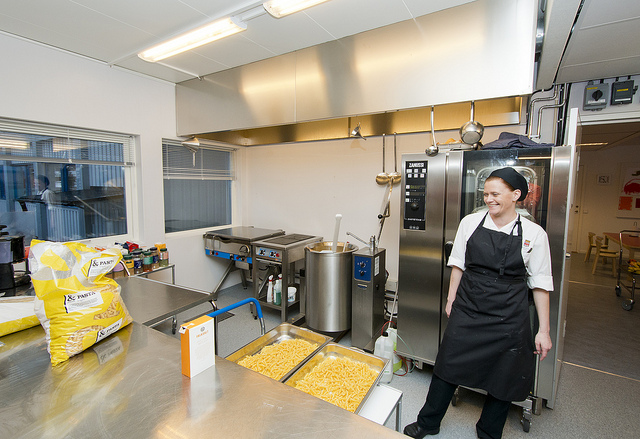

Q1: Is there a map in the picture?
A1: no



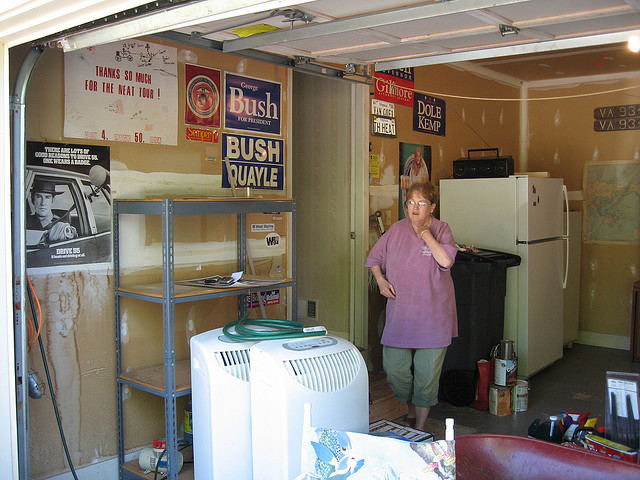

Q2: Is there a map in the picture?
A2: yes



In [12]:
qid = sample['question_id'][1]

ex1 = qid_to_example[qid]
ex2 = qid_to_example[comp_q[qid]]

display(Image(filename=os.path.join('data/coco/raw/train2014', ex1['image_name'])))
print("Q1: {}\nA1: {}\n".format(ex1['question'], ex1['answer']))

display(Image(filename=os.path.join('data/coco/raw/train2014', ex2['image_name'])))
print("Q2: {}\nA2: {}\n".format(ex2['question'], ex2['answer']))

In [51]:
sample['question_id'][0]

496401003

In [15]:
ex1

{'answer': 'no',
 'answer_aid': 1,
 'answers': ['no', 'yes'],
 'answers_aid': [1, 0],
 'answers_count': [9, 1],
 'answers_occurence': [['no', 9], ['yes', 1]],
 'image_name': 'COCO_train2014_000000539737.jpg',
 'question': 'Is there a map in the picture?',
 'question_id': 539737008,
 'question_length': 7,
 'question_wids': [17,
  7055,
  5060,
  7585,
  6936,
  721,
  6877,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'question_words': ['is', 'there', 'a', 'map', 'in', 'the', 'picture'],
 'question_words_UNK': ['is', 'there', 'a', 'map', 'in', 'the', 'picture'],
 'seq_length': 7}

In [ ]:
for i, sample in enumerate(train_loader):
    
    # Get complementary q_ids
    q_ids_comp = [comp_q[q_id] for q_id in sample['question_id']]
    
    break

In [69]:
qid_to_example[sample['question_id'][0]]

{'answer': 'pole',
 'answer_aid': 374,
 'answers': ['pole', 'parking meter', 'street sign', 'sign', 'red', 'nothing'],
 'answers_aid': [374, 463, 1192, 261, 7, 16],
 'answers_count': [2, 1, 1, 1, 1, 1],
 'answers_occurence': [['pole', 2],
  ['parking meter', 1],
  ['paper box', 1],
  ['street sign', 1],
  ['sign', 1],
  ['red', 1],
  ['police call post', 1],
  ['nothing', 1],
  ['light post', 1]],
 'image_name': 'COCO_train2014_000000496401.jpg',
 'question': 'What object is red and blue?',
 'question_id': 496401003,
 'question_length': 6,
 'question_wids': [4623,
  7700,
  17,
  8253,
  4370,
  8868,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'question_words': ['what', 'object', 'is', 'red', 'and', 'blue'],
 'question_words_UNK': ['what', 'object', 'is', 'red', 'and', 'blue'],
 'seq_length': 6}

In [32]:
knns = np.load("data/coco/extract/arch,fbresnet152_size,448/knn/knn_results_trainset.npy").reshape(1)[0]
knn_idx = knns["indices"]

In [34]:
knn_idx.shape

(82783, 25)

In [35]:
# Get KNNs for original images
iids_orig = [trainset.dataset_img.name_to_index[image_name] for image_name in sample['image_name']]

# TODO
knns_batch = [list(knn_idx[i]) for i in iids_orig]

In [41]:
f = h5py.File('data/coco/extract/arch,fbresnet152_size,448/trainset.hdf5', 'r')
features = f.get('att')
features[0].shape

(2048, 14, 14)

In [49]:
knn_features = [[features[i] for i in knns_batch[j]] for j in tqdm(range(len(knns_batch)))]


 36%|███▌      | 46/128 [03:00<05:21,  3.92s/it]

KeyboardInterrupt: 

In [79]:
# Get complementary q_ids (or None if question has no compliment)
qids_comp = [comp_q[qid] if qid in comp_q else None for qid in sample['question_id']]

In [80]:
# Get complementary image_names
image_names_comp = [qid_to_example[qid]['image_name'] if qid else None for ex in q_ids_comp]

In [ ]:
# Check if comp image in KNNs